In [1]:
import os

url_path = "https://raw.githubusercontent.com/bzitko/nlp_repo/main/assignments/a05/"
downloads = {"surnames_with_splits.csv.bz2": "surnames_with_splits.csv",
             "nlp.py": None}

for download_name, extract_name in downloads.items():
    if extract_name and os.path.exists(extract_name):
        continue

    if not os.path.exists(download_name):
        import requests
        response = requests.get(f"{url_path}{download_name}")
        with open(download_name, "wb") as fp:
            fp.write(response.content)
        response.close()

    if not extract_name:
        continue

    _, ext = os.path.splitext(download_name)
    if ext == ".bz2":    
        import bz2
        with open(download_name, 'rb') as bzf, open(extract_name, 'wb') as fp:
            fp.write(bz2.decompress(bzf.read()))
    elif ext == ".zip":
        from zipfile import ZipFile
        with ZipFile(download_name) as zf:
            zf.extractall(path=".")


# SOLUTION: Generating Surnames with a RNN

## Imports

In [2]:
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


from nlp import StepByStep, Vectorizer, Vocabulary
from itertools import chain

def allclose(a, b, atol=1e-4):
    if not isinstance(a, torch.Tensor):
        a = torch.tensor(a)
    if not isinstance(b, torch.Tensor):
        b = torch.tensor(b)
    return torch.allclose(a, b, atol=atol)

## Dataframes

In [3]:
surname_df = pd.read_csv("surnames_with_splits.csv").drop(["nationality_index"], axis=1)

train_df = surname_df[surname_df.split == "train"]
val_df = surname_df[surname_df.split == "val"]
test_df = surname_df[surname_df.split == "test"]

## Vocabulary

👍
Create variables:
* `nationality_vocab` as instance of `Vocabulary` filled with nationalities from `train_df`
* `surname_vocab` as instance of `Vocabulary` which is filled with all letters from all surnames in `train_df` and whose special tokens are:
    * unknown token = `@`,
    * begin token = `<`
    * end token = `>` 
    * unknown token = `@`.
* `max_surname_size` is length of the longest surname in `train_df` increases by **2** (since begin and end tokens are added to padded surname)

In [4]:
nationality_vocab = Vocabulary()
nationality_vocab.fill(train_df.nationality)

surname_vocab = Vocabulary(pad_tok=".", unk_tok="@", bgn_tok="<", end_tok=">")
surname_vocab.fill(chain(*train_df.surname))
max_surname_size = max(train_df.surname.apply(len)) + 1 # for begin and end tok

# test
# assert max_surname_size == 18, f"your max_surname_size is {max_surname_size}, not 18 "
# assert torch
# assert allclose(surname_vocab.pad("johnson", 10), [39, 44, 37, 43, 48, 44, 43,  1,  0,  0]), f"padding of 'johnson' with size 10 shuld be [39, 44, 37, 43, 48, 44, 43,  1,  0,  0]"

## Splitting

For X values surnames are padded accordint to `max_surname_size`.

In [5]:
# datasets

def vectorize(split_df, surname_vocab, nationality_vocab, max_surname_size):
    pad_idx = surname_vocab[surname_vocab.pad_tok]

    x = surname_vocab.pad_many(split_df.surname, size=max_surname_size)
    x_batch_size, _ = x.shape
    
    h = nationality_vocab.vocabularize(split_df.nationality)
    
    y_pad = torch.full(size=(x_batch_size, 1), fill_value=pad_idx)
    y = torch.cat([x[:,1:], y_pad], dim=1)

    return x, h, y

x_train, h_train, y_train = vectorize(train_df, surname_vocab, nationality_vocab, max_surname_size)        
x_val, h_val, y_val = vectorize(val_df, surname_vocab, nationality_vocab, max_surname_size)        
x_test, h_test, y_test = vectorize(test_df, surname_vocab, nationality_vocab, max_surname_size)        

## Dataset

In [6]:
class SurnameDataset(Dataset):

    def __init__(self, x_tensor, h_tensor, y_tensor):
        self.x = x_tensor
        self.h = h_tensor
        self.y = y_tensor

    def __getitem__(self, index):
        return self.x[index], self.h[index], self.y[index]
    
    def __len__(self):
        return len(self.x)

## Model overview


Surname vocabulary $|V^\text{sur}| = v^\text{sur}_{size}$

Nationality vocabulary $|V^\text{nat}| = v^\text{nat}_{size}$

Surname $\vec{s} = \begin{bmatrix} s_1 & s_2 & ... & s_n \end{bmatrix}  \\$

Vocabularization of surname $\vec{x} = V^\text{sur}(\vec{s}) = \begin{bmatrix} V^\text{sur}(s_1) & V^\text{sur}(s_2) & ... & V^\text{sur}(s_n) \end{bmatrix} = \begin{bmatrix} x_1 & x_2 & ... & x_n \end{bmatrix}$

Nationality $nat$

Vocabularization of nationality $\vec{h} = V^\text{nat}(s) = \begin{bmatrix} V^\text{nat}(nat) \end{bmatrix} = \begin{bmatrix} h_0 \end{bmatrix}$

Vocabularization of nationality $h = 
$$
\vec{x} = \begin{bmatrix} x_1 & x_2 & ... & x_n \end{bmatrix}  \\
y = \begin{bmatrix} x_2 & x_3 & ... & x_{n-1} & 0\end{bmatrix} \\

\vec{e_x} = E^x(\vec{x}) \\ 
\vec{h_x} = E^h(x) \\
\hat{y} = GRU(e_x, e_x)

$$



### Step 1: Vocabulary

Let vocabulary $V$ contain 25 letters a, b, c, ..., z, and 4 special tokens:
* `'.'` - pad token
* `'<'` - begin of sequence token
* `'>'` - end of token sequence
* `'*'` - unknown token

$V=\{.,<,>,a,b,c,...,z,*\}$

$v_{size} = |V|=25 + 4 = 29$

In [7]:
V = Vocabulary(pad_tok=".", bgn_tok="<", end_tok=">", unk_tok="@")
V.fill("abcdefghijklmnopqrstuvxyz")
v_size = len(V)

print("V =", V)
print("v_size =", v_size)

V = Vocabulary({'.': 0, '<': 1, '>': 2, '@': 3, 'a': 4, 'b': 5, 'c': 6, 'd': 7, 'e': 8, 'f': 9, 'g': 10, 'h': 11, 'i': 12, 'j': 13, 'k': 14, 'l': 15, 'm': 16, 'n': 17, 'o': 18, 'p': 19, 'q': 20, 'r': 21, 's': 22, 't': 23, 'u': 24, 'v': 25, 'x': 26, 'y': 27, 'z': 28})
v_size = 29


### Step 2: Vectorization with fixed size

Let maximal number of letters in surname $s_{size}$ is 10.

$s_{size} = 10$

Vectorization of the surname 'adams' with padding is

$x = V(adams) = [1, 4, 7, 4, 16, 22, 2, 0, 0, 0]$

In [8]:
surname = "adams"
s_size = 10
x = V.pad(surname, size=s_size)

print("surname =", surname)
print("s_size =", s_size)
print("x =", x.tolist())

surname = adams
s_size = 10
x = [1, 4, 7, 4, 16, 22, 2, 0, 0, 0]


### Step 3: Embedding

Let $E$ be embedding layer having shape $v_{size} \times e_{dim}$ where $e_{dim}$ is 15.

Then $e_x = E(x)$ is embedding vector of the surname 'adams' and shape of $e_x$ is $s_{size} \times e_{dim}$


In [9]:
e_dim = 15
E = nn.Embedding(num_embeddings=v_size, embedding_dim=e_dim, padding_idx=0)
e_x = E(x)

print("E shape =", tuple(E.weight.shape))
print("e_x shape =", tuple(e_x.shape))

E shape = (29, 15)
e_x shape = (10, 15)


### Step 4: RNN

Let RNN has input dimension of $e_{dim}$ and hidden dimension $h_{dim}$ = 4.

Forward propagation of $x$ and first hidden vector $h_0 = [0, 0, 0, 0]$ is

$h_{all}, h_{s_{size}}=RNN(x, h_0)$

where $h_{all}$ contains all activations in time including the last activation $h_{s_{size}}$.


In [10]:
h_dim = 4
h_0 = torch.zeros(1, h_dim) # torch requires that h_0 is in batch
R = nn.RNN(input_size=e_dim, hidden_size=4, batch_first=True)
h_all, h_s_size = R(e_x, h_0)

print("h_dim =", h_dim)
print("h_0 =", h_0.tolist())

print("h_all shape =", tuple(h_all.shape))
print("h_s_size shape =", tuple(h_s_size.shape))
print("last row in h_all =", h_all[-1].tolist())
print("h_s_size =", h_s_size.tolist())



h_dim = 4
h_0 = [[0.0, 0.0, 0.0, 0.0]]
h_all shape = (10, 4)
h_s_size shape = (1, 4)
last row in h_all = [0.3002602756023407, 0.6396384239196777, -0.3852819800376892, -0.37780871987342834]
h_s_size = [[0.3002602756023407, 0.6396384239196777, -0.3852819800376892, -0.37780871987342834]]


### Step 5: Two Linear layers

Let $FC1$ is linear layer of shape $h_{dim} \times h_{dim}$.

Let $c_{dim}$ be an size of an output (number of classes)

Let $FC2$ is linear layer of shape $h_{dim} \times c_{dim}$.

Then 

$\hat{y} = FC2(ReLU(FC1(h_{s_{size}})))$

In [11]:
c_dim = 3
FC1 = nn.Linear(in_features=h_dim, out_features=h_dim)
FC2 = nn.Linear(in_features=h_dim, out_features=c_dim)

y_hat = FC2(F.relu(FC1(h_s_size.squeeze())))

print("y_hat shape =", tuple(y_hat.shape))


y_hat shape = (3,)


## The Model: SurnameGenerator
👍 Create `SurnameGenerator` class as RNN width following methods:

Method `__init__(self, in_num_emb, in_emb_size, h_num_emb, h_emb_size, rnn_num_layers, batch_first=True, padding_idx=0)` initializes classifier with
* `num_emb` - number of embeddings is $v_{size}$
* `emb_size` - dimension of embedding is $e_{dim}$
* `rnn_hidden_size` - dimension of hidden layer of RNN is $h_{dim}$
* `num_classes` - dimension of output (number of classes) is $c_{dim}$

Crete layers according to Model overview presented in the cells above.

Method `forward(self, x, h=None)` for forward propagation according to Model overciew presented in the cells above.

NOTE: Use dropout with $p=0.5$ for all inputs into each fully connected layer.

In [12]:
class SurnameGenerator(torch.nn.Module):
    def __init__(self, 
                 in_num_emb, in_emb_size,
                 h_num_emb, h_emb_size,
                 rnn_num_layers=1,
                 batch_first=True, padding_idx=0, dropout_p=0.25):
                 
        super(SurnameGenerator, self).__init__()

        self.batch_first = batch_first
        self.rnn_num_layers=rnn_num_layers
        self.dropout_p = dropout_p

        self.in_emb = torch.nn.Embedding(num_embeddings=in_num_emb,
                                         embedding_dim=in_emb_size,
                                         padding_idx=padding_idx)
        
        self.h_emb = torch.nn.Embedding(num_embeddings=h_num_emb,
                                        embedding_dim=h_emb_size)
        
        self.rnn = torch.nn.GRU(input_size=in_emb_size, 
                                hidden_size=h_emb_size,
                                num_layers=rnn_num_layers,
                                batch_first=batch_first)
        
        self.fc = torch.nn.Linear(h_emb_size, in_num_emb)
        self.drop = torch.nn.Dropout(p=dropout_p)



    def forward(self, x, h=None):
        x_emb = self.in_emb(x)
        
        # repeat nationality tensor by the number of rnn layers
        h_emb = self.h_emb(h).repeat((self.rnn_num_layers, 1, 1)) if h is not None else None
        
        y_hat, last_hidden = self.rnn(x_emb, h_emb)

        y_hat = self.fc(y_hat)
        y_hat = self.drop(y_hat)
        
        return y_hat    


# test
StepByStep.set_seed(96)
model = SurnameGenerator(in_num_emb=len(surname_vocab), in_emb_size=100,
                         h_num_emb=len(nationality_vocab), h_emb_size=64,
                         rnn_num_layers=1,
                         padding_idx=surname_vocab[surname_vocab.pad_tok], batch_first=True,
                         dropout_p=0.25)

dataset = SurnameDataset(x_train, h_train, y_train)
loader = DataLoader(dataset, batch_size=3, shuffle=True)
x, h, y = next(iter(loader))

model.h_emb(h)
y_hat = model(x, h)


## Loss

In [13]:
def batch_nll_loss_fn(y_hat, y):
    y_hat = F.log_softmax(y_hat, dim=-1)
    losses = []
    for b_y_hat, b_y in zip(y_hat, y):
        lv = F.nll_loss(b_y_hat, b_y, ignore_index=surname_vocab[surname_vocab.pad_tok])
        losses.append(lv)
    return torch.stack(losses).mean()

# Train

Epoch: 113  train loss: 2.74711 val loss: 2.32141 lr: 1.52587890625e-08

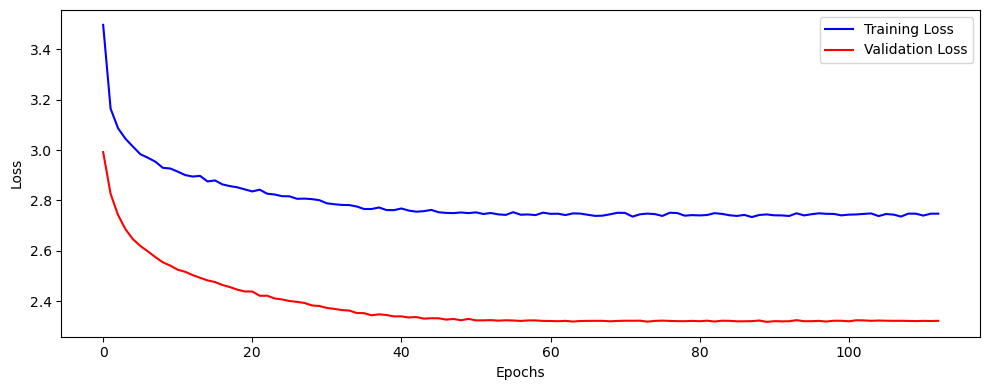

In [14]:
StepByStep.set_seed(96)

model = SurnameGenerator(in_num_emb=len(surname_vocab), in_emb_size=32,
                         h_num_emb=len(nationality_vocab), h_emb_size=16,
                         rnn_num_layers=1,
                         padding_idx=surname_vocab[surname_vocab.pad_tok], batch_first=True,
                         dropout_p=0.25)

loss_fn = batch_nll_loss_fn
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

train_loader = DataLoader(SurnameDataset(x_train, h_train, y_train), batch_size=64, drop_last=True, shuffle=True)
val_loader = DataLoader(SurnameDataset(x_val, h_val, y_val), batch_size=64, drop_last=True, shuffle=True)

sbs = StepByStep(model, loss_fn, optimizer, scheduler)
sbs.set_loaders(train_loader, val_loader)

sbs.train_by_loss_change(1e-4)

sbs.plot_losses(ylog=False)


## Sampling

In [18]:
StepByStep.set_seed(96)

def generate_samples_for_nationalities(model, surname_vocab, nationality_vocab, max_surname_size, num_samples=5):

    def generate_sample(nationality):
        h = torch.tensor([nationality_vocab[nationality]])
        sample = surname_vocab.bgn_tok
        while sample[-1] not in (surname_vocab.end_tok, surname_vocab.pad_tok) and len(sample) < max_surname_size:
            x = surname_vocab.vocabularize(sample).unsqueeze(0)
            y_hat = model(x, h)
            probs = F.softmax(y_hat[-1][-1], dim=-1).detach()
            next_char_i = torch.multinomial(probs, num_samples=1).item()
            next_char = surname_vocab.inverse[next_char_i]
            sample += next_char
            if next_char in (surname_vocab.bgn_tok, surname_vocab.end_tok) :
                break
        return sample.strip(surname_vocab.bgn_tok + surname_vocab.end_tok + surname_vocab.pad_tok)
    
    model.eval()
    for nationality in nationality_vocab:
        print(nationality)
        for _ in range(num_samples):
            sample = generate_sample(nationality)
            print(f" - {sample}")

generate_samples_for_nationalities(model, surname_vocab, nationality_vocab, max_surname_size, num_samples=3)

Arabic
 - Tautsg
 - Agdrateh
 - Sadite
Chinese
 - Yan
 - Doma
 - Toir
Czech
 - eranhau-kasta
 - EnTeef
 - Molbündelep
Dutch
 - Febkold
 - Eschchityerry
 - Dilengit
English
 - Maegprysko
 - Kiderger
 - Narsysin
French
 - TlDis
 - Ilczov
 - AbusTnda
German
 - ThanrBurgyrrvo
 - Maln
 - cav
Greek
 - Endcianíy
 - Sharuz
 - Cor
Irish
 - Revtan
 - Hosronen
 - Malrikile
Italian
 - Gougfo
 - Bulo
 - xorditsamáky
Japanese
 - Ni
 - MGias
 - lyemazuma
Korean
 - Ketsev
 - Kud
 - Yaog
Polish
 - Fuso
 - Uvtost
 - Doe'Bochla
Portuguese
 - Huekohn
 - Saila
 - Turriu
Russian
 - Vabniguyasove
 - Ylade
 - Heshiby
Scottish
 - HLybing
 - sewobby
 - Bugy
Spanish
 - Dogla
 - bibHaf
 - UProri
Vietnamese
 - Gou
 - Zas
 - Cs


In [138]:
def sample_from_model(model, vocab, num_samples=10, nationality_idx=None):
    model.eval()
    # encode
    x_0 = torch.tensor([vocab[vocab.bgn_tok] for _ in range(num_samples)])
    samples = [x_0]

    if nationality_idx:
        h_0 = torch.tensor([nationality_idx for _ in range(num_samples)])
    else:
        h_0 = None

    
    for t in range(max_surname_size):
        x_t = samples[t].unsqueeze(1)
        model(x_t, h_0)
        y_t = model(x_t, h_0)

        pred = y_t.squeeze(1)
        prob = F.softmax(pred, dim=-1)
        indices = torch.multinomial(prob, num_samples=1).squeeze()
        samples.append(indices)
    
    samples = torch.stack(samples, dim=1)
    
    # decode
    surnames = []
    for sample in samples:
        surname = ""
        for num in sample.tolist():
            char = vocab.inv[num]
            if char == vocab.bgn_tok:
                continue
            if char == vocab.end_tok:
                break
            surname += char
        surnames.append(surname)
    
    return surnames

sample_from_model(model, surname_vocab, nationality_idx=4)

['PHfNaflrDYeBREfwof',
 'EYöfNDKirexWwVilrV',
 'GllTTPerßZydIrxPpD',
 'SwChELßWiIqinLdlJr',
 'MnewAnRYKxOrWnDNCD',
 'YERrüwConWrInHerPq',
 'WLVlYLIflrlIlBNopw',
 'TlJOLFMAfpSuHamlSr',
 'VMJEnQZollAuUnDMwI',
 'KrvCErVOGlrUdLouxa']

In [139]:
import sys
import time
for i in range(10):
  sys.stdout.write(str(i))
  sys.stdout.flush()
  time.sleep(0.5)
  sys.stdout.write('\b')
print("opla")


opla
